<h3>Importing Libs<h3>

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

<h3>Device</h3>

In [94]:
torch.__version__

'2.8.0+cu126'

In [95]:
torchvision.__version__

'0.23.0+cu126'

In [96]:
torch.cuda.is_available()

True

In [97]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


<h3>Reproducibility</h3>

In [98]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

<h3>Hyperparameters</h3>

In [99]:
BATCH_SIZE=128
EPOCHS=20
LEARNING_RATE=3e-4
PATCH_SIZE=4
NUM_CLASSES=10
IMAGE_SIZE=32
CHANNELS=3
EMBED_DIM=256
NUM_HEADS=8
DEPTH=6
MLP_DIM=512
DROPOUT_RATE=0.05

<h3>Image Transformations + Data Augmentation</h3>




In [183]:
# transform_train=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))                    # It takes transforms.dropout(mean,std) ...
#                                                                          # we have 3(RGB) channels as its a colorful dataset so we are taking dropouts individually for each channel
# ])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),                                  # Crops the image 32*32 patch after padding
    transforms.RandomHorizontalFlip(),                                     # Adding flips
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


<h3> Seggregating the dataset </h3>

In [184]:
train_dataset=datasets.CIFAR10(root="data",
                               train=True,
                               download=True,
                               transform=transform_train)

In [185]:
test_dataset=datasets.CIFAR10(root="data",
                               train=False,
                               download=True,
                               transform=transform_train)

In [186]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [187]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [188]:
len(train_dataset),len(test_dataset)

(50000, 10000)

<h3>Data to DataLoaders for Batching</h3>

In [189]:
train_loader=DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        )

In [190]:
test_loader=DataLoader(dataset=test_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      )

In [191]:
print(f"DataLoaders are : {train_loader,test_loader}")

DataLoaders are : (<torch.utils.data.dataloader.DataLoader object at 0x7a3a73637c80>, <torch.utils.data.dataloader.DataLoader object at 0x7a3a73ec9370>)


In [192]:
print(f"Length of DataLoaders are : {len(train_loader),len(test_loader)}")

Length of DataLoaders are : (196, 40)


In [193]:
50000/128

390.625

In [194]:
10000/128

78.125

In [195]:
BATCH_SIZE

256

<h3>Building ViT</h3>

In [196]:
# The intuition is that we have a Patch of tensor (B,N,E) where N is W/P, H/P then we add an extra classification token of tensor (B,1,E)
# Then we concatenate both of them so tensor becomes (B,N+1,E) and lastly adding the positional embeddingsas transformer doesn't have learnt or stored them like LSTM and GRU'S

class PatchEmbedding(nn.Module):
  def __init__(self,img_size,patch_size,in_channels,embed_dim):
    super().__init__()
    self.patch_size=patch_size
    self.proj=nn.Conv2d(in_channels=in_channels,out_channels=embed_dim,kernel_size=patch_size,stride=patch_size)
    num_patches=(img_size//patch_size)**2
    self.cls_token=nn.Parameter(torch.randn(1,1,embed_dim))                      #(1,1,E)
    self.pos_embed=nn.Parameter(torch.randn(1,1+num_patches,embed_dim))          #(1,1+N,E)

  def forward(self,x:torch.Tensor):
    B=x.size(0)                                          # Here B is the batch size which has the number of images in this batch
    x=self.proj(x)                                       # (B, E, H/P, W/P) after calling proj
    x=x.flatten(2).transpose(1,2)                        # (B, N, E) and N is N = (H/P) * (W/P)      and reason of  transpose is the input acceptance form of the transformer
                                                         # Transformers work with sequence-first representations
    cls_tokens=self.cls_token.expand((B,-1,-1))          # -1 means do not change this dimension So now (B,1,E)
    x=torch.cat((cls_tokens,x),dim=1)                    # (B,N+1,E) Classification token concatenated
    x=x+self.pos_embed
    return x

In [197]:
# The MCP takes the features and it enriches them by first expanding them via linear neural layer then applying a non linear actuivation function and then again adding a linear nn
# adding the dropouts to ensure no overfitting
# Not using relu as it is harsh for a structure like Transformer we needed a smooth function that doesnot completely cuts off but keeps a little bit info of the features to the next layer
# So we use Gaussian error linear unit

class MultiLayerPerceptron(nn.Module):
  def __init__(self,in_features,hidden_features,dropout_rate):
    super().__init__()
    self.fc1=nn.Linear(in_features=in_features,out_features=hidden_features)
    self.fc2=nn.Linear(in_features=hidden_features,out_features=in_features)
    self.dropout=nn.Dropout(dropout_rate)

  def forward(self,x):
    x=self.fc1(x)
    x=F.gelu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    x=self.dropout(x)
    return x

In [198]:
class EncoderLayer(nn.Module):
  def __init__(self,embed_dim,num_heads,mlp_dim,dropout_rate):
    super().__init__()
    self.norm1=nn.LayerNorm(embed_dim)                                  # We apply norm only on embed dims because we have a fear of values to shrink or explode so we
                                                                        # re initialize the mean and std and get alpha and gamma shifts
                                                                        # We want to normalize individually not across batch wise or seq length so we apply them only to embed dims
    self.attention=nn.MultiheadAttention(embed_dim,num_heads,dropout_rate,batch_first=True)
    self.norm2=nn.LayerNorm(embed_dim)
    self.mlp=MultiLayerPerceptron(embed_dim,mlp_dim,dropout_rate)

  def forward(self,x):
    x= x + self.attention(self.norm1(x),self.norm1(x),self.norm1(x))[0]      # Output form is this but we want output only and ignore the weights
                                                                        # attn_output, attn_weights = self.attn(query, key, value)
    x= x + self.mlp(self.norm2(x))
    return x

In [199]:
# The OG vision transformer class

class ViT(nn.Module):
  def __init__(self,img_size,patch_size,in_channels,num_classes,embed_dim,depth,num_heads,mlp_dim,dropout_rate):
    super().__init__()
    self.patch_embeds=PatchEmbedding(img_size,patch_size,in_channels,embed_dim)
    self.encoder=nn.Sequential(*[EncoderLayer(embed_dim,num_heads,mlp_dim,dropout_rate)
                               for _ in range(depth) ])                  # We used * because else it would take the complete list of number of layers and treat them as a single module
                                                                         # It won't iterate throught the layers individually hence the forward pass would break
                                                                         # But if we add a * for unnpacking of list it treats each layer differently
    self.norm=nn.LayerNorm(embed_dim)
    self.head=nn.Linear(embed_dim,num_classes)                           # The head takes the input dims and then

  def forward(self,x):
    x=self.patch_embeds(x)
    x=self.encoder(x)
    x=self.norm(x)
    cls_token=x[:,0]                                                     # The shape is [B,N+1,embed_dim] but we only want the cls token across all the batches
                                                                         # So we are extracting the classification token after updating it holds the important information of the about the patches
    return self.head(cls_token)


<h3>Incorporating the Transformer</h3>

In [200]:
model = ViT(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROPOUT_RATE
).to(device)

In [201]:
model

ViT(
  (patch_embeds): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): EncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MultiLayerPerceptron(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): EncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MultiLayerP

<h3>Loss Function and the Optimizer</h3>

In [202]:
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=LEARNING_RATE)

<h3>Training Loop</h3>

In [203]:
def train(model,loader,optimizer,loss_function):
  model.train()                                                           # Training mode
  total_loss,correct=0,0
  for x,y in loader:
    x,y=x.to(device),y.to(device)
    optimizer.zero_grad()                                                 # We don't want the old iteration gradients So we clear them by zeroing
    output=model(x)
    loss=loss_function(output,y)
    loss.backward()
    optimizer.step()                                                      # Updation of the gradients
    correct+=(output.argmax(1)==y).sum().item()                           # summing up all the correct predictions
    total_loss+=loss.item()*x.size(0)                                     # the average loss per sample for this batch (loss.item()), Multiplying by x.size(0) (batch size) gives the sum of losses for all samples in this batch
  return total_loss/len(loader.dataset),correct/len(loader.dataset)       # average loss per sample over the whole dataset and correct part gives the accuracy


# Got confused here :
# # For better understanding

# loss.item() = average loss per sample in the batch.
# Multiply by batch size → total loss of that batch.          (batch_sizes are different)
# Add for all batches → total loss of dataset.
# Divide by dataset size → average loss per sample for whole dataset.
# Similarly for correct / len(loader.dataset), gives accuracy.

<h3> Evaluation Loop </h3>

In [204]:
def evaluate(model,loader):
  model.eval()                                                             # Evaluation mode
  correct=0
  with torch.inference_mode():                                            # turning on the inference mode to make preds by the model
    for x,y in loader:
      x,y=x.to(device),y.to(device)
      output=model(x)
      correct+=(output.argmax(dim=1)==y).sum().item()
    return correct / len(loader.dataset)


<h3>Training </h3>

In [205]:
train_accuracies,test_accuracies=[],[]

for epoch in tqdm(range(EPOCHS)):
  train_loss,train_acc=train(model,train_loader,optimizer,loss_function)
  test_acc=evaluate(model,test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch : {epoch+1}/{EPOCHS} , Train Loss: {train_loss:.4f} , Train Accuracy {train_acc:.4f}% , Test Accuracy {test_acc}%")

  5%|▌         | 1/20 [00:58<18:35, 58.72s/it]

Epoch : 1/20 , Train Loss: 1.8889 , Train Accuracy 0.3079% , Test Accuracy 0.3972%


 10%|█         | 2/20 [01:55<17:13, 57.44s/it]

Epoch : 2/20 , Train Loss: 1.5853 , Train Accuracy 0.4234% , Test Accuracy 0.4698%


 15%|█▌        | 3/20 [02:50<16:02, 56.60s/it]

Epoch : 3/20 , Train Loss: 1.4615 , Train Accuracy 0.4698% , Test Accuracy 0.5008%


 20%|██        | 4/20 [03:47<15:04, 56.50s/it]

Epoch : 4/20 , Train Loss: 1.3694 , Train Accuracy 0.5055% , Test Accuracy 0.5219%


 25%|██▌       | 5/20 [04:43<14:08, 56.57s/it]

Epoch : 5/20 , Train Loss: 1.3079 , Train Accuracy 0.5285% , Test Accuracy 0.5301%


 30%|███       | 6/20 [05:40<13:10, 56.45s/it]

Epoch : 6/20 , Train Loss: 1.2525 , Train Accuracy 0.5503% , Test Accuracy 0.5622%


 35%|███▌      | 7/20 [06:36<12:14, 56.49s/it]

Epoch : 7/20 , Train Loss: 1.1976 , Train Accuracy 0.5691% , Test Accuracy 0.5739%


 40%|████      | 8/20 [07:32<11:16, 56.41s/it]

Epoch : 8/20 , Train Loss: 1.1572 , Train Accuracy 0.5840% , Test Accuracy 0.5928%


 45%|████▌     | 9/20 [08:29<10:19, 56.35s/it]

Epoch : 9/20 , Train Loss: 1.1276 , Train Accuracy 0.5945% , Test Accuracy 0.5976%


 50%|█████     | 10/20 [09:25<09:23, 56.39s/it]

Epoch : 10/20 , Train Loss: 1.0870 , Train Accuracy 0.6144% , Test Accuracy 0.6029%


 55%|█████▌    | 11/20 [10:21<08:26, 56.27s/it]

Epoch : 11/20 , Train Loss: 1.0440 , Train Accuracy 0.6279% , Test Accuracy 0.612%


 60%|██████    | 12/20 [11:17<07:30, 56.26s/it]

Epoch : 12/20 , Train Loss: 1.0252 , Train Accuracy 0.6353% , Test Accuracy 0.6238%


 65%|██████▌   | 13/20 [12:14<06:35, 56.48s/it]

Epoch : 13/20 , Train Loss: 0.9949 , Train Accuracy 0.6455% , Test Accuracy 0.6317%


 70%|███████   | 14/20 [13:11<05:39, 56.58s/it]

Epoch : 14/20 , Train Loss: 0.9578 , Train Accuracy 0.6566% , Test Accuracy 0.6529%


 75%|███████▌  | 15/20 [14:08<04:42, 56.52s/it]

Epoch : 15/20 , Train Loss: 0.9259 , Train Accuracy 0.6701% , Test Accuracy 0.6568%


 80%|████████  | 16/20 [15:05<03:46, 56.66s/it]

Epoch : 16/20 , Train Loss: 0.9024 , Train Accuracy 0.6778% , Test Accuracy 0.6669%


 85%|████████▌ | 17/20 [16:02<02:50, 56.78s/it]

Epoch : 17/20 , Train Loss: 0.8718 , Train Accuracy 0.6886% , Test Accuracy 0.6767%


 90%|█████████ | 18/20 [16:58<01:53, 56.72s/it]

Epoch : 18/20 , Train Loss: 0.8442 , Train Accuracy 0.7000% , Test Accuracy 0.6696%


 95%|█████████▌| 19/20 [17:55<00:56, 56.80s/it]

Epoch : 19/20 , Train Loss: 0.8145 , Train Accuracy 0.7110% , Test Accuracy 0.6809%


100%|██████████| 20/20 [18:52<00:00, 56.64s/it]

Epoch : 20/20 , Train Loss: 0.7887 , Train Accuracy 0.7193% , Test Accuracy 0.7021%


In [206]:
train_accuracies

[0.30792,
 0.42338,
 0.46978,
 0.50552,
 0.52848,
 0.55026,
 0.56912,
 0.58398,
 0.59448,
 0.61436,
 0.6279,
 0.6353,
 0.6455,
 0.65658,
 0.67014,
 0.67778,
 0.68864,
 0.69998,
 0.71104,
 0.71932]

In [207]:
test_accuracies

[0.3972,
 0.4698,
 0.5008,
 0.5219,
 0.5301,
 0.5622,
 0.5739,
 0.5928,
 0.5976,
 0.6029,
 0.612,
 0.6238,
 0.6317,
 0.6529,
 0.6568,
 0.6669,
 0.6767,
 0.6696,
 0.6809,
 0.7021]

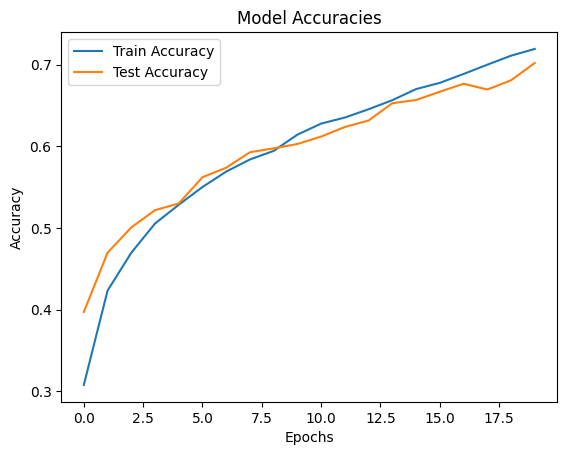

In [208]:
plt.plot(train_accuracies,label="Train Accuracy")
plt.plot(test_accuracies,label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracies")
plt.legend()
plt.show()

<h3>Plotting Predictions</h3>

In [209]:
def plots(model,dataset,classes,grid_size=3):
  model.eval()                                               # Setting the model to evaulation state
  fig,axes=plt.subplots(grid_size,grid_size,figsize=(9,9))    # Creates a big image with small axes of 3*3 each axes contains a prediction image and target label
  for i in range(grid_size):                                 # Iterating through rows
    for j in range(grid_size):                               # Iterating through columns
      index=random.randint(0,len(dataset)-1)
      img , true_label= dataset[index]                       # getting the image and true label acc to random index
      input_tensor= img.unsqueeze(dim=0).to(device)          # img is in [Channel,Height,Width]shape but our model expects the first entry to be the batch_size so adding a dim
                                                             # Now - [1,Channel,Height,Width]... added to device because matplot lib expects both the image and model in same environment
      with torch.inference_mode():                           # The backprop and other functions in back stop which increases speed so adding in inference mode
        output=model(input_tensor)                           # [1,num_classes] format
        _,predicted= torch.max(output.data,1)                # _ becuase we don't need batch size to be unpacked so taking a temp variable
                                                             # Now we need maximum from the output probs across the dimension 1(num_classes)
      img=img/2 + 0.5                                        # Matplotlib doesn't takes negative tensors in image visualization
      npimg= img.cpu().numpy()                               # Matplotlib doesn't works on PyTorch Tensors
      axes[i,j].imshow(np.transpose(npimg,(1,2,0)))          # Matplotlib imshow() expects us to have channels in last dim so we transpose
      truth= classes[true_label]==classes[predicted.item()]  # .item() converts the tensor predicted class to integer
      if truth:
        color="g"
      else:
        color="r"
      axes[i, j].set_title(f"Truth: {classes[true_label]}\n Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
      axes[i, j].axis("off")
  plt.tight_layout()
  plt.show()


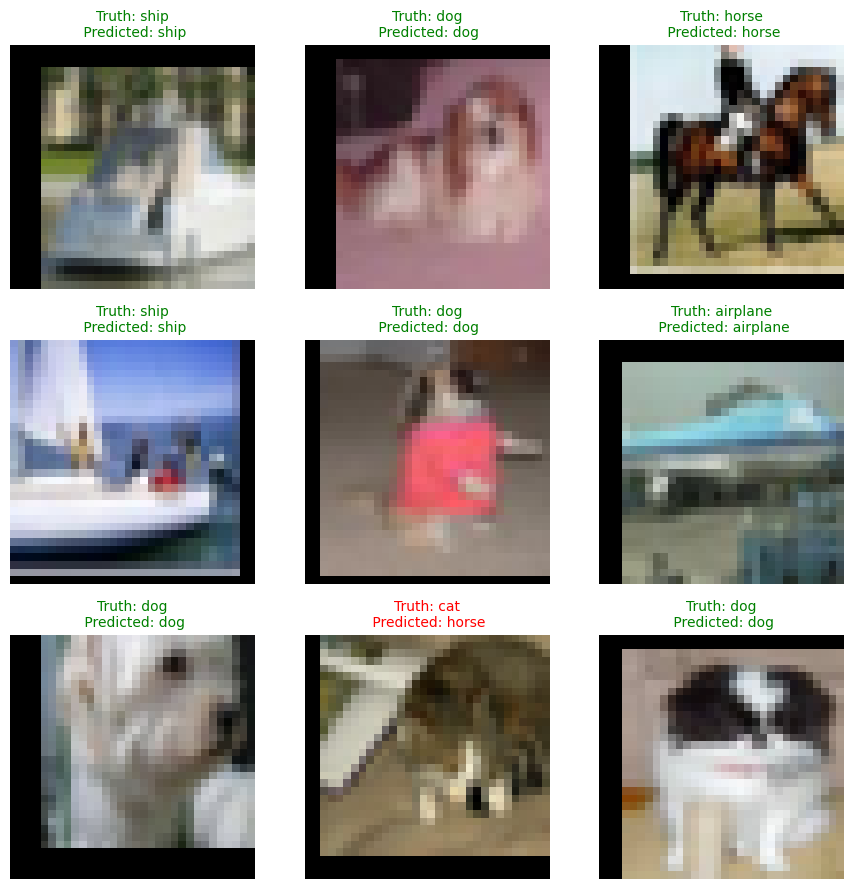

In [211]:
plots(model, test_dataset, classes=train_dataset.classes, grid_size=3)